a


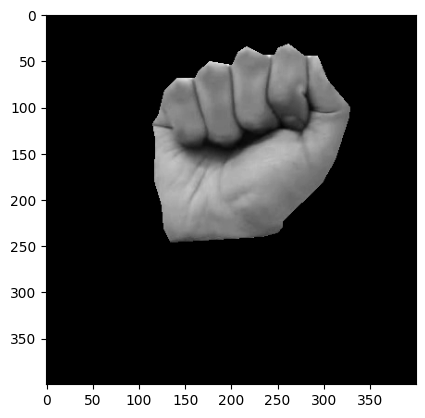

In [1]:
import os
import numpy as np
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt

# get the images from the folder 
def getImages(dirpath):
    dpath = os.path.join(os.getcwd(), dirpath)     # make full directory path
    imgs = []
    letters = []
    
    for img in os.listdir(dpath):
        imgpath = os.path.join(dpath, img)
        letters.append(img[:1])                 # get image letter from file name
        imgs.append(cv.imread(imgpath, 0))    # add in gray scale image

    return imgs, letters

imgs, letters = getImages(r"Dataset_ASL_Hand_Gestures\Dataset_ASL_Hand_Gestures\rotated_scaled _grayscale_frames")
plt.figure()
plt.imshow(imgs[0], cmap='gray')          # print an image
print(letters[0])


[[120  34  16 ... 128  66   1]
 [120  34  16 ... 128  74   3]
 [ 88  34  24 ...   8  11   3]
 ...
 [ 34 188 225 ...  78 255 222]
 [ 91  48 121 ... 132  71 119]
 [104  48 120 ... 128  70 115]]


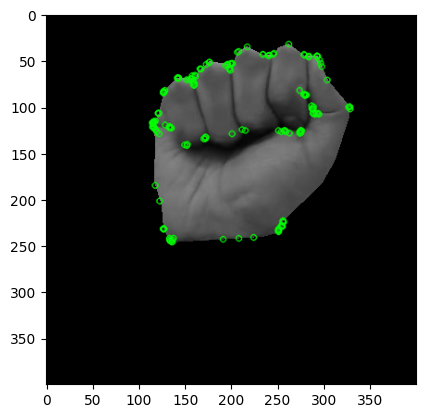

(<matplotlib.image.AxesImage at 0x18145483430>, None)

In [2]:
orb = cv.ORB_create(nfeatures = 500)              # create orb feature detection

kp = orb.detect(imgs[0],None)
kp, des = orb.compute(imgs[0], kp)
print(des)

img2 = cv.drawKeypoints(imgs[0], kp, None, color=(0,255,0), flags=0)

plt.imshow(img2), plt.show()

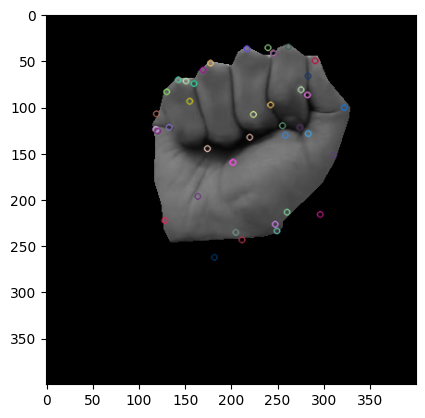

(<matplotlib.image.AxesImage at 0x181454e39d0>, None)

In [3]:
sift = cv.SIFT_create()

kp = sift.detect(imgs[0],None)

img3 = cv.drawKeypoints(imgs[0],kp,imgs[0])

plt.imshow(img3), plt.show()

In [4]:
# get the features from an image with ORB
def getFeaturesORB(img):
    kp = orb.detect(img, None)
    kp, des = orb.compute(img, kp)    # get the features of the image with orb

    return kp, des

# get features from image with SIFT
def getFeaturesSIFT(img):           # get features with sift
    kp, des = sift.detectAndCompute(img, None)

    return kp, des

def getDescriptors1(gimgs, min = 1000, m = 0):       # dosent work
    fimgs = []
    
    for img in gimgs:
        kp = orb.detect(img, None)
        kp, des = orb.compute(img, kp)   # compute descriptors for all teh images
    
        fimgs.append(np.array(des))
        if (des.shape[0] < min) and (m == 0):             # find the minimum amount of features found
            min = des.shape[0]
    
    for i in range(0, len(fimgs)):
        fimgs[i] = np.reshape(np.array(fimgs[i][:min]), (min*32))
        
    fimgs = np.stack(fimgs)
    print(fimgs.shape)

    return fimgs, min

# get descriptors and 
def getDescriptors(gimgs, min = 1000, m = 0):
    imgf = []
    fimgs = []
    
    for img in gimgs:
        kp, des = getFeaturesORB(img)   # compute descriptors for all teh images
    
        imgf= np.array(des)
        if (des.shape[0] < min) and (m == 0):             # find the minimum amount of features found
            min = des.shape[0]

        for i in range(0, len(imgf)):
            fimgs.append(imgf[i])    # append all descriptors to one array
        
    print(np.array(fimgs).shape)
    return fimgs, min

def reduceDim(fimgs, min):       # may not be necessary ( can use as a normalizaiton function)
    for i in range(0, len(fimgs)):
        fimgs[i] = fimgs[i][:min]      # make fimgs homogenous shape
        
    print(np.array(fimgs).shape)
    return np.array(fimgs)

i_train, i_test, l_train, l_test = train_test_split(imgs, letters, test_size = 0.15, random_state = 1)       # split data

#train_fimgs, min = getDescriptors(i_train)
#i_train = reduceDim(train_fimgs, min)

#test_fimgs, min2 = getDescriptors(i_test, min, 1)
#i_test = reduceDim(test_fimgs, min)

i_train_f, min = getDescriptors(i_train)
i_test_f, min2 = getDescriptors(i_test, min, 1)

(555196, 32)
(97882, 32)


In [5]:
#kmeans clustering
kmeans = KMeans(n_clusters = 100, random_state = 1, n_init = 'auto').fit(i_train_f)
dictionary = kmeans.cluster_centers_

In [6]:
#build BoW vectors

def getBoWvector(img, dictionary):
    hg = np.zeros(len(dictionary))    # create empty histogram

    kp, des = getFeaturesORB(img)        # get features
    num_features = len(des)

    for feature in des:                        # for each feature in image
        dists = []
        for word in dictionary:                     # for each word in the dictionary
            dists.append(np.linalg.norm(feature - word))         # get distance

        cluster = np.argmin(dists)    # nearest word
        hg[cluster] += 1

    hg /= num_features            # normalize histogram
    
    return hg       # return histogram


BoW_train = []

for img in i_train:
    hg = getBoWvector(img, dictionary)        # get BoW vector for each training image
    BoW_train.append(hg)

In [7]:
#knn

knn = KNeighborsClassifier(n_neighbors = 2, weights = 'distance', metric = 'euclidean') # create cluster for each letter

knn.fit(BoW_train, l_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=2, weights='distance')

In [8]:
BoW_test = []
for img in i_test:
    hg = getBoWvector(img, dictionary)
    BoW_test.append(hg)

pred = knn.predict(BoW_test)
print(pred)
print(l_test)

def getAccuracy(pred, labels):
    countCor = 0
    
    for i in range(0, len(pred)):
        if pred[i] == labels[i]:
            countCor += 1

    countCor /= len(pred)

    print(f"The accuracy was {countCor}.")

getAccuracy(pred, l_test)

['a' 'm' 's' 'r' 'v' 'h' 'h' 'b' 'd' 'c' 'e' 'y' 'k' 'u' 'e' 'v' 'n' 's'
 'g' 'b' 'e' 'e' 'p' 'h' 'm' 'v' 'y' 'd' 'x' 'g' 'u' 'i' 'w' 'n' 'l' 'u'
 'v' 'h' 'q' 't' 'h' 'p' 'f' 'o' 'l' 'a' 'y' 'y' 'b' 'f' 'g' 'o' 'a' 'e'
 'e' 'w' 'g' 'c' 'd' 't' 'b' 'x' 'h' 'i' 'o' 'w' 'a' 'x' 'c' 'r' 'f' 'v'
 'y' 'h' 'w' 'c' 't' 'k' 't' 'p' 'o' 'd' 'a' 'f' 'u' 'w' 'u' 'h' 'o' 'v'
 'i' 'r' 'i' 'q' 'o' 'u' 'p' 'o' 'v' 'd' 'r' 'h' 'o' 'm' 'a' 'f' 's' 'm'
 'a' 'r' 'd' 'm' 't' 'w' 'a' 'a' 's' 'y' 'i' 'n' 'e' 'm' 'y' 'q' 'b' 'k'
 'b' 'r' 'f' 'x' 'w' 'p' 's' 'u' 'p' 'e' 'k' 'g' 'r' 'f' 'k' 'o' 'o' 'u'
 't' 'q' 'g' 'a' 'm' 'g' 'c' 'x' 'x' 'a' 'c' 'k' 'g' 'u' 'w' 'h' 'd' 'n'
 'p' 'c' 'd' 'e' 'p' 'g' 'q' 'n' 'e' 'd' 'g' 'm' 'n' 'v' 'l' 'r' 'd' 'r'
 'l' 'k' 'h' 'i' 'l' 'f' 'd' 'v' 'e' 'c' 'm' 'y' 'h' 'r' 'u' 'w' 'r' 'y'
 'i' 'x' 'p' 'u' 'y' 'l' 'e' 'f' 'f' 'l' 'l' 's' 'w' 'k' 'e' 'x' 'y' 'i'
 'r' 'x' 'k' 'd' 'o' 'y' 'p' 'a' 'm' 'f' 'e' 'e' 'c' 'c' 'g' 'p' 'i' 'k'
 'm' 'i' 'x' 'o' 'o' 'w' 'u' 'q' 'o' 'b' 'g' 'q' 'c